# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

# Skip-gram Word2Vec with Negative Sampling



## Word2Vec

* Here we implement **skip-gram architecture** with **negative sampling**, as it performs better than CBOW and trains faster than negative sampling.

* Given a word, it has to predict the surrounding words: it has to learn representations of words that have a similar context.

In [1]:
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'

## Get the data

Download the data as the previous notebook.

In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
!rm -r pytorch-tutorial-nlp-public

In [44]:
# from the folder containing the data, obtain the list of all the files
from glob import glob
file_list = glob( "/content/data/Shakespeare/*.txt")

print(file_list)

['/content/data/Shakespeare/1515-0.txt', '/content/data/Shakespeare/1102.txt', '/content/data/Shakespeare/1101.txt', '/content/data/Shakespeare/1128.txt', '/content/data/Shakespeare/1508-0.txt', '/content/data/Shakespeare/1514-0.txt', '/content/data/Shakespeare/1513.txt', '/content/data/Shakespeare/1517.txt', '/content/data/Shakespeare/1510.txt', '/content/data/Shakespeare/1519-0.txt']


In [45]:
text = ''
for p in file_list:
  with open(p, 'r') as f:
    lines = f.readlines()
    for l in lines:
      text += l

In [46]:
print(text[:100])

﻿Dramatis Personæ

THE DUKE OF VENICE
THE PRINCE OF MOROCCO, suitor to Portia
THE PRINCE OF ARRAGON,


# 2. Pre-process text

* Convert any punctuation into tokens, e.g. a period is changed to ` <PERIOD> `. (Note: `text8` dataset doesn't contain any periods.)
* Remove all words that show up ≤5 times in the dataset to
  * reduce issues due to noise in the data
  * improve the quality of the vector representations
* Return a list of preprocessed words in the text

In [47]:
import re
from collections import Counter

def preprocess(text):

    # Convert all text to lowercase
    text = text.lower()

    # Replace punctuation with tokens so we can use them in our model
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()

    # Remove all words with 5 or less occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [48]:
# get vocabulary
words = preprocess(text)
print(text[:100])
print(words[:30])

﻿Dramatis Personæ

THE DUKE OF VENICE
THE PRINCE OF MOROCCO, suitor to Portia
THE PRINCE OF ARRAGON,
['the', 'duke', 'of', 'venice', 'the', 'prince', 'of', 'morocco', '<COMMA>', 'suitor', 'to', 'portia', 'the', 'prince', 'of', 'arragon', '<COMMA>', 'suitor', 'to', 'portia', 'antonio', '<COMMA>', 'a', 'merchant', 'of', 'venice', 'bassanio', '<COMMA>', 'his', 'friend']


In [49]:
print("Total # of words: {}".format(len(words)))
print("# of unique words: {}".format(len(set(words))))

Total # of words: 291011
# of unique words: 3504


# 3. Create Dictionaries

Sorted in descending frequency order (e.g. most frequent word `"the"` is assigned as `0`).


In [50]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    - words: list of words
    - return: 2 dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words) # Create a dictionary of 'word': word count
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)} # vocabulary idx: 'word'
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()} # vocabulary 'word': idx

    return vocab_to_int, int_to_vocab

In [51]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words] # get the idx of the word in the list of words
print(vocab_to_int)
print(int_to_vocab)
print(int_words)

{'<COMMA>': 0, '<PERIOD>': 1, 'the': 2, 'and': 3, 'i': 4, 'to': 5, 'of': 6, '<SEMICOLON>': 7, 'a': 8, 'you': 9, 'my': 10, 'in': 11, '<QUESTION_MARK>': 12, 'that': 13, 'is': 14, '<EXCLAMATION_MARK>': 15, 'not': 16, 'with': 17, 'for': 18, 'me': 19, 'it': 20, 'be': 21, 'this': 22, 'your': 23, 'his': 24, '<COLON>': 25, 'but': 26, 'will': 27, 'have': 28, 'he': 29, 'as': 30, 'thou': 31, 'so': 32, 'her': 33, 'him': 34, 'what': 35, 'by': 36, 'thy': 37, 'or': 38, 'no': 39, 'if': 40, 'all': 41, 'shall': 42, 'are': 43, 'do': 44, 'thee': 45, 'we': 46, 'king': 47, 'on': 48, 'come': 49, 'now': 50, 'sir': 51, ']': 52, 'at': 53, 'good': 54, 'she': 55, 'love': 56, 'from': 57, 'am': 58, '<HYPHENS>': 59, 'our': 60, 'well': 61, 'how': 62, 'here': 63, 'lord': 64, 'then': 65, 'o': 66, 'they': 67, 'more': 68, 'would': 69, 'man': 70, 'let': 71, 'go': 72, 'an': 73, 'when': 74, 'may': 75, 'hath': 76, 'was': 77, 'which': 78, 'one': 79, 'them': 80, 'than': 81, 'say': 82, 'there': 83, 'their': 84, 'why': 85, 'see'

vdvdvasdvsdvsdv# 4. Perform Word Subsampling

* Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words.
* Discarding some of them (aka Subsampling) can achieve :
  * **removing of noise in data**
  * faster training
  * better representations.
* Each word $w_i$ in the training set is discarded with probability:
  * $t$ : threshold (something small like 1e-5)
  * $f(w_i)$ : frequency (in decimals) of word $w_i$

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

* Use: discard if `random.random() < probs[word]`

In [52]:
import random
import numpy as np

def subsample_words(int_words, threshold = 1e-5):
  word_counts = Counter(int_words)
  total_n_words = len(int_words)

  freq_ratios = {word: count / total_n_words for word, count in word_counts.items()}
  p_drop = {word: 1 - np.sqrt(threshold / freq_ratios[word]) for word in word_counts}

  return [word for word in int_words if random.random() < (1 - p_drop[word])]

In [53]:
  train_words = subsample_words(int_words)
  print(len(int_words))
  print(len(train_words))
  print(len(train_words)/len(int_words)) # around the 11% of the word are sampled from the whole set of

291011
33744
0.11595437973135037


# 5. Generate Context Targets

For each word in the text, define **_Context_** by grabbing the surrounding words in a window of size $C$.

In [54]:
import random
def get_target(words, idx, max_window_size=5):
    R = random.randint(1, max_window_size)
    start = max(0, idx - R)
    end = min(idx + R, len(words) - 1)
    targets = words[start : idx] + words[idx + 1 : end + 1] # +1 since doesn't include this idx
    return targets

We are combining contexts with random windows size in order to have a trade off between syntax and semantics

In [55]:
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

for _ in range(5):
  target = get_target(int_text, idx=idx, max_window_size=5)
  print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]
Target:  [4, 6]
Target:  [2, 3, 4, 6, 7, 8]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]
Target:  [4, 6]


# 6. Generate Batches

* Grab `batch_size` words from a words list
* Then for each of those words, get the context target words in a window.

In [56]:
def get_batches(words, batch_size, max_window_size=5):
  # only full batches
  n_batches = len(words) // batch_size # get the number of batches
  words = words[: n_batches * batch_size] # get the tiotal words excluding the one outside the last batch
  for i in range(0, len(words), batch_size):
    batch_of_center_words = words[i : i + batch_size]   # current batch of words
    batch_x, batch_y = [], []

    for ii in range(len(batch_of_center_words)):  # range(batch_size) unless truncated at the end, here I range to each word in the given batch
      x = [batch_of_center_words[ii]]             # single word
      y = get_target(words = batch_of_center_words, idx = ii, max_window_size = max_window_size)  # list of context words

      batch_x.extend(x * len(y)) # repeat the center word (n_context_words) times
      # extend the batch_x with a list that is the id of the context word repeated len(y) times

      batch_y.extend(y)

    yield batch_x, batch_y       # ex) [1,1,2,2,2,2,3,3,3,3], [0,2,0,1,3,4,1,2,4,5]

In [57]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, max_window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 2]


# 7. Define COSINE SIMILARITY Function for Validation Metric

* Choose a few common words & a few uncommon words
* Print their **closest words** using Cosine Similarity:

<img src="https://github.com/lukysummer/SkipGram_with_NegativeSampling_Pytorch/blob/master/assets/two_vectors.png?raw=1" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

In [58]:
def cosine_similarity(embedding, n_valid_words=16, valid_window=100):
  """ Returns the cosine similarity of validation words with words in the embedding matrix.
      embedding: PyTorch embedding module
      n_valid_words: # of validation words (recommended to have even numbers)
  """
  all_embeddings = embedding.weight  # (n_vocab, n_embed)
  # sim = (a . b) / |a||b|
  magnitudes = all_embeddings.pow(2).sum(dim=1).sqrt().unsqueeze(0) # (1, n_vocab)

  # Pick validation words from 2 ranges: (0, window): common words & (1000, 1000+window): uncommon words
  valid_words = random.sample(range(valid_window), n_valid_words // 2) + random.sample(range(1000, 1000 + valid_window), n_valid_words // 2)
  valid_words = torch.LongTensor(np.array(valid_words)).to(device) # (n_valid_words, 1)

  valid_embeddings = embedding(valid_words) # (n_valid_words, n_embed)
  # (n_valid_words, n_embed) * (n_embed, n_vocab) --> (n_valid_words, n_vocab) / (1, n_vocab)
  similarities = torch.mm(valid_embeddings, all_embeddings.t()) / magnitudes  # (n_valid_words, n_vocab)

  return valid_words, similarities

# 8. Define SkipGram model with [Negative Sampling](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)


Instead of updating all tokens' embeddings, approximate the loss from softmax layer by only updating a small subset of weights assciated with:
* center word
* context words
* noise words

In the model, we use 2 separate embedding tables, one for input words & one for output words.



In [59]:
import torch
from torch import nn
import torch.optim as optim

* `nn.Embedding` layer is the same as a Linear layer with one-hot-encoded input. You could define the layer as `nn.Linear(1000, 30)` & represent each word as a one-hot vector, e.g., `[0,0,1,0,...,0]` where the length of the vector is 1000.

* It is an ***embedding lookup table*** which is just a weight matrix & the lookup is just a shortcut for the matrix multiplication.

* It is trained just like any weight matrix.

# Question 1
Complete the following with the correct implementation.

In [60]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()

        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist


        self.in_embed = nn.Embedding(n_vocab, n_embed) #''' COMPLETE_HERE '''
        self.out_embed = nn.Embedding(n_vocab, n_embed) #''' COMPLETE_HERE '''
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)


    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words) #''' COMPLETE_HERE '''
        return input_vectors  # input vector embeddings


    def forward_target(self, output_words):
        output_vectors = self.out_embed(output_words) #''' COMPLETE_HERE '''
        return output_vectors  # output vector embeddings


    def forward_noise(self, batch_size, n_samples=5):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        # If no Noise Distribution specified, sample noise words uniformly from vocabulary
        if self.noise_dist is None:
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist

        if n_samples==0:
            noise_vectors = None
        else:
          # torch.multinomial :
          # Returns a tensor where each row contains (num_samples) **indices** sampled from
          # multinomial probability distribution located in the corresponding row of tensor input.
          noise_words = torch.multinomial(input       = noise_dist,           # input tensor containing probabilities
                                          num_samples = batch_size*n_samples, # number of samples to draw
                                          replacement = True)
          noise_words = noise_words.to(device)

          # use context matrix for embedding noise samples
          noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)

        return noise_vectors

# 9. Define Loss Class
Modified loss function that only cares about :
* current example
* small subset of noise examples

## Loss Formula
$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_N}\hspace{0.001em}^\top v_{w_I}\right)}
$$

* $u_{w_O}\hspace{0.001em}$ : output embeddings
* $v_{w_I}$ : input embeddings
* $u_{w_N}$ : noise embeddings



$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

* Take the **log-sigmoid** of the **inner product of output word vector & input word vector**.
  * Pushes *P(model will predict the correct word $w_O$)* towards 1.

$$\large \sum_i^N \mathbb{E}_{w_N \sim P_n(w)}$$

* Sum over words $w_N$ drawn from a noise distribution $w_N \sim P_n(w)$.
* For $P_n(w)$, we can use the unigram distribution $U(w)$ that takes into account the frequency that each word shows up in text corpus.
* The authors found the best distribution to be $U(w)^{3/4}$.

$$\large \log{\sigma\left(-u_{w_N}\hspace{0.001em}^\top v_{w_I}\right)},$$

* take the **log-sigmoid** of the ***negated*** **inner product of a noise vector with the input vector**.
  * Pushes *P(model will predict the noise words)* towards 0.

In [61]:
class NegativeSamplingLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,
              input_vectors,
              output_vectors,
              noise_vectors):

    batch_size, embed_size = input_vectors.shape

    input_vectors = input_vectors.view(batch_size, embed_size, 1)   # batch of column vectors
    output_vectors = output_vectors.view(batch_size, 1, embed_size) # batch of row vectors

    # log-sigmoid loss for correct pairs
    out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()

    # log-sigmoid loss for incorrect pairs
    if noise_vectors is None:
      noise_loss = 0.0
    else:
      noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
      noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

    return -(out_loss + noise_loss).mean()  # average batch loss

# 10. Define Noise Distribution

In [62]:
# As defined in the paper by Mikolov et all.
freq = Counter(int_words)
freq_ratio = {word: cnt / len(vocab_to_int) for word, cnt in freq.items()}
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum()
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

# 11. Define Model, Loss, & Optimizer

In [81]:
from torch import optim

embedding_dim = 20
model = SkipGramNeg(len(vocab_to_int),
                                 embedding_dim,
                                 noise_dist )
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

# 12. Train!

In [82]:
def train_skipgram(model,
                   criterion,
                   optimizer,
                   int_words,
                   n_negative_samples=5,
                   batch_size=128,
                   n_epochs=10,
                   print_every=1500,
                   ):
  model.to(device)

  step = 0
  for epoch in range(n_epochs):
    for inputs, targets in get_batches(int_words, batch_size=batch_size):
      step += 1
      inputs = torch.LongTensor(inputs).to(device)    # [b*n_context_words]  ----  [b*n_context_words*len(int_words)]
      targets = torch.LongTensor(targets).to(device)  # [b*n_context_words]  ----  [b*n_context_words*len(int_words)]

      embedded_input_words = model.forward_input(inputs)
      embedded_target_words = model.forward_target(targets)
      embedded_noise_words = model.forward_noise(batch_size=inputs.shape[0],
                                                  n_samples=n_negative_samples)

      loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (step % print_every) == 0:
        print("Epoch: {}/{}".format((epoch+1), n_epochs))
        print("Loss: {:.4f}".format(loss.item()))
        valid_idxs, similarities = cosine_similarity(model.in_embed)
        _, closest_idxs = similarities.topk(6)
        valid_idxs, closest_idxs = valid_idxs.to('cpu'), closest_idxs.to('cpu')

        # here the only demands will be to use properly the dictionary
        for ii, v_idx in enumerate(valid_idxs):
          closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
          print(int_to_vocab[v_idx.item()] + " | "+ ", ".join(closest_words))

        print("\n...\n")

In [83]:
train_skipgram(model,
               criterion,
               optimizer,
               int_words,
               n_negative_samples=5)

Epoch: 1/10
Loss: 2.5877


TypeError: ignored

# 13. Visualise the embeddings in 2D space

# Question 2
See if by plotting the embeddings in a 2D space you can see some clusters.

In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [67]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [68]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

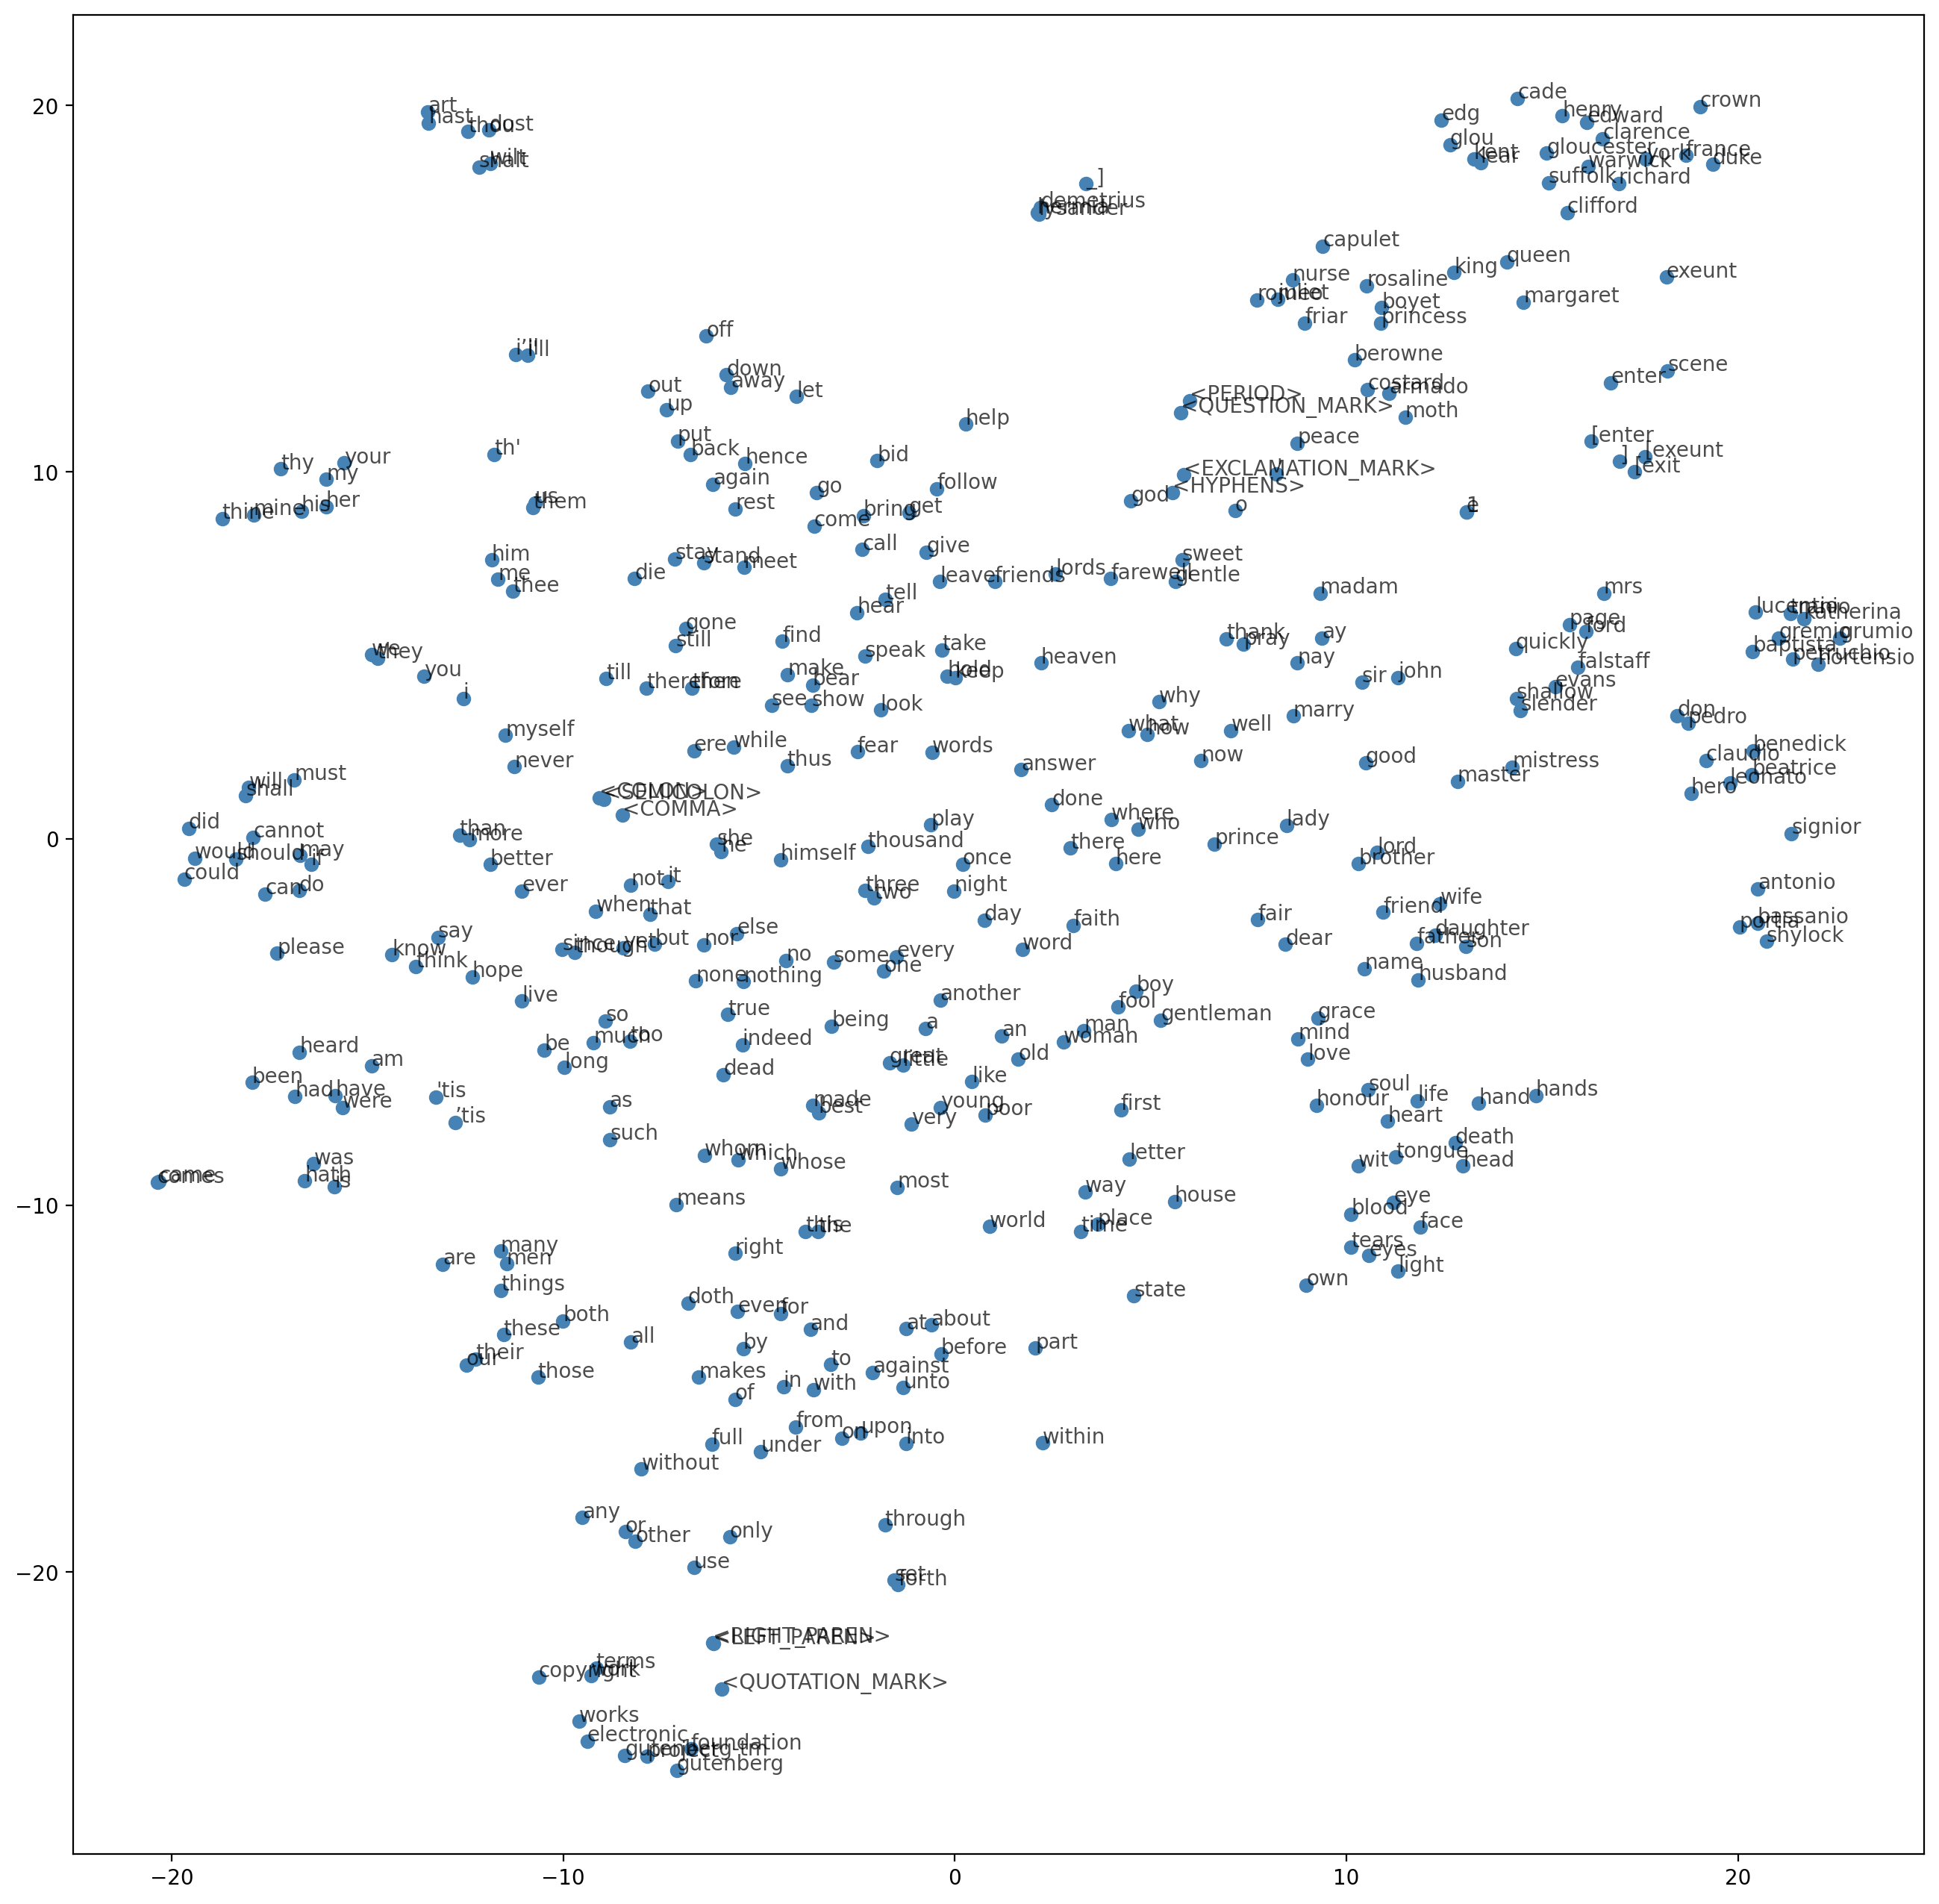

In [69]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Additional Plot Analysis

In the additional analysis we decided to consider the given words to obtain the top_k similar words, to make a better visualization to see the similar words near each other.

In [70]:
list_indices = [vocab_to_int['would'] , vocab_to_int['hand'], vocab_to_int['friend'], vocab_to_int['my'], vocab_to_int['york'], vocab_to_int['antonio'] , vocab_to_int['grumio'], vocab_to_int['wife']]

list_colors = ['orange', 'green', 'red', 'brown', 'magenta', 'yellow', 'black', 'purple']

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
import random

embedds_similarity = cosine_similarity(embeddings)

np.fill_diagonal(embedds_similarity, -1.0)

In [72]:
def get_words_similarity(embedds_similarity, n_words_pr_idx_list, top_k):
  dict_to_return = {}
  if(type(n_words_pr_idx_list) != list):
    range_embedds = range(len(embedds_similarity))
    n_words_pr_idx_list = random.sample(range_embedds, n_words_pr_idx_list)

  for idx_word in n_words_pr_idx_list:
    most_similar_words_idx = np.flip(np.argsort(embedds_similarity[idx_word]))[:top_k]
    most_similar_words_str = [int_to_vocab[idx] for idx in most_similar_words_idx]
    most_similar_words_sim = [embedds_similarity[idx_word, idx] for idx in most_similar_words_idx]

    dict_to_return[idx_word] = most_similar_words_idx

    print(f'Most similar word for "{int_to_vocab[idx_word]}" are:\t{most_similar_words_str}')
    print(f'With corresponding indices:\t{most_similar_words_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_words_sim}\n')

  return dict_to_return

In [73]:
most_sim_words = get_words_similarity(embedds_similarity, list_indices, 5)

Most similar word for "would" are:	['could', 'did', 'should', 'might', 'dare']
With corresponding indices:	[242 105  90 380 650]
With corresponding Embedding Cosine Similarity of:	[0.88800013, 0.86142105, 0.859601, 0.8373129, 0.8099637]

Most similar word for "hand" are:	['dagger', 'picture', 'death', 'blessing', 'manhood']
With corresponding indices:	[1799 2585  143 1708 2724]
With corresponding Embedding Cosine Similarity of:	[0.8375407, 0.7876886, 0.7808997, 0.758616, 0.75626534]

Most similar word for "friend" are:	['father', 'conscience', 'lord', 'daughter', 'gentleman']
With corresponding indices:	[ 116 1194   64  201  289]
With corresponding Embedding Cosine Similarity of:	[0.81378984, 0.8094518, 0.7894527, 0.763225, 0.74246544]

Most similar word for "my" are:	['your', 'her', 'his', 'mine', 'thy']
With corresponding indices:	[ 23  33  24 121  37]
With corresponding Embedding Cosine Similarity of:	[0.83272535, 0.8277393, 0.7544799, 0.7412177, 0.74015945]

Most similar word for "

Compared to the skip gram without negative sampling the embedding results are better. Words that are similar to each other make sense and have a high similarity.

Compared to the previous version of skipgram without negative samplig we obtained much consistent and better results.

In [74]:
def plot_point_features(x, y, dictionary):
  plt.figure(figsize=(10, 10))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['orange', 'green', 'red', 'brown', 'magenta', 'yellow', 'black', 'purple']
  j = 0

  for target_index, list_idx_words in dictionary.items():

      plot.text(x[target_index], y[target_index], int_to_vocab[target_index], horizontalalignment='center', size='small', color=list_colors[j], weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_words]
      top_similar_y = [y[i] for i in list_idx_words]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {int_to_vocab[target_index]}')
      j += 1

  plt.legend()
  plt.show()

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
W_dec_TSNE = tsne.fit_transform(embeddings)
x_W_dec_TSNE = W_dec_TSNE[:, 0]
y_W_dec_TSNE = W_dec_TSNE[:, 1]

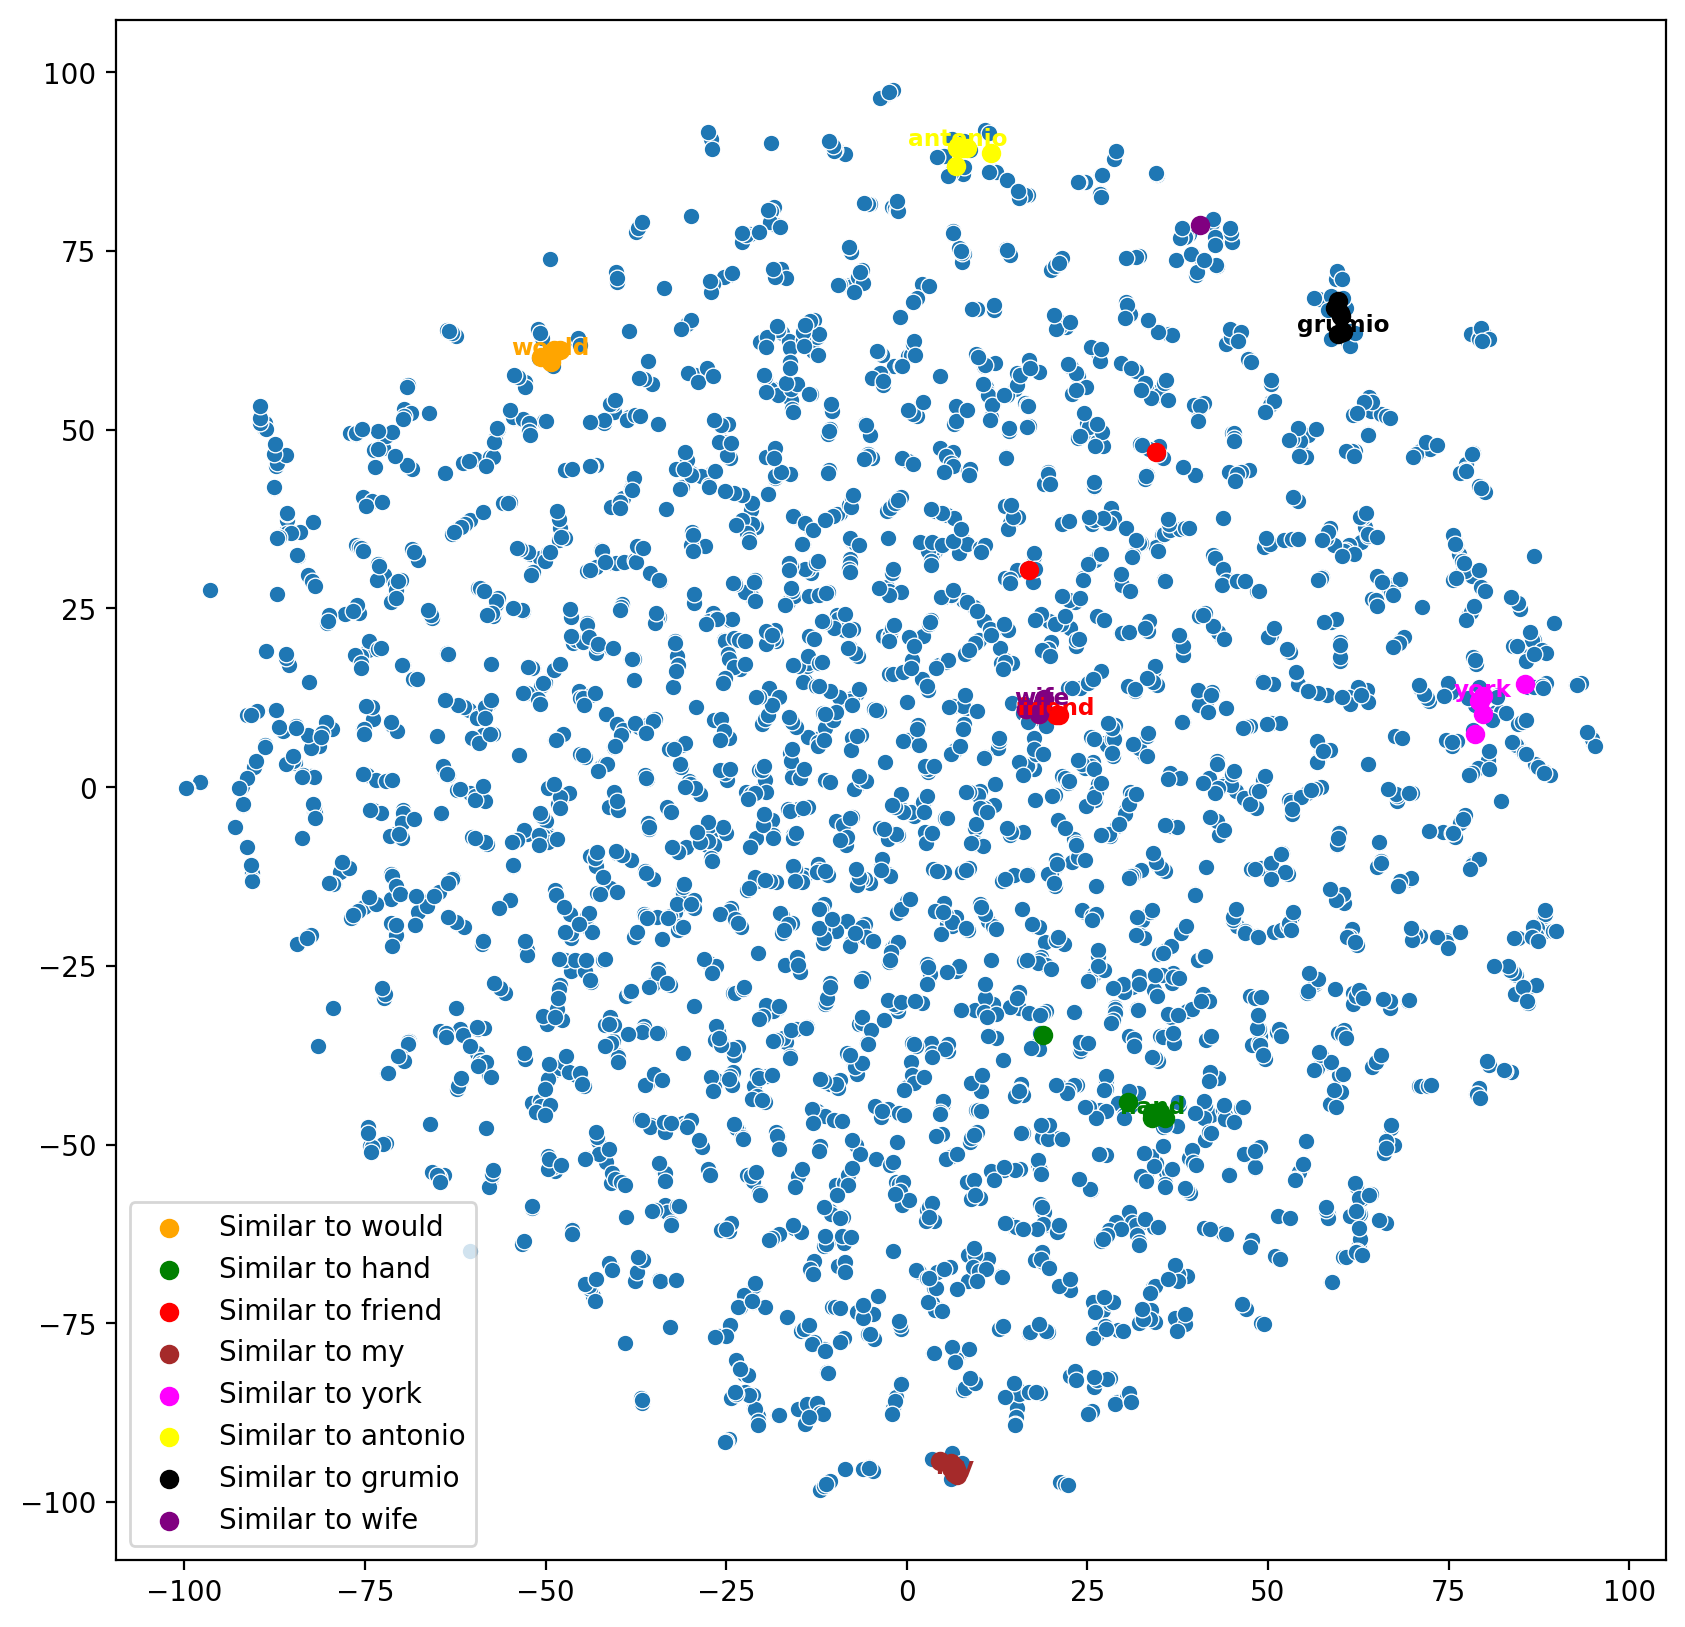

In [76]:
plot_point_features(x_W_dec_TSNE, y_W_dec_TSNE, most_sim_words)

From the previous two notebook that we have completed and analysed, the TSNE dimensionaly reduction strategy tries to group embeddings that have high similarity to each other forming a single cluster. Indeed TSNE is suitable to represent highly dimensional data in a 2D space.

Indeed as expecded about all the words that are similar to the words that we have taken are close to each other, indicating that each set of word is similar to the given examined word.

In [77]:
from sklearn import decomposition

svd = decomposition.TruncatedSVD(n_components=2)
W_dec_PCA = svd.fit_transform(embeddings)
x_W_dec_PCA = W_dec_PCA[:, 0]
y_W_dec_PCA = W_dec_PCA[:, 1]

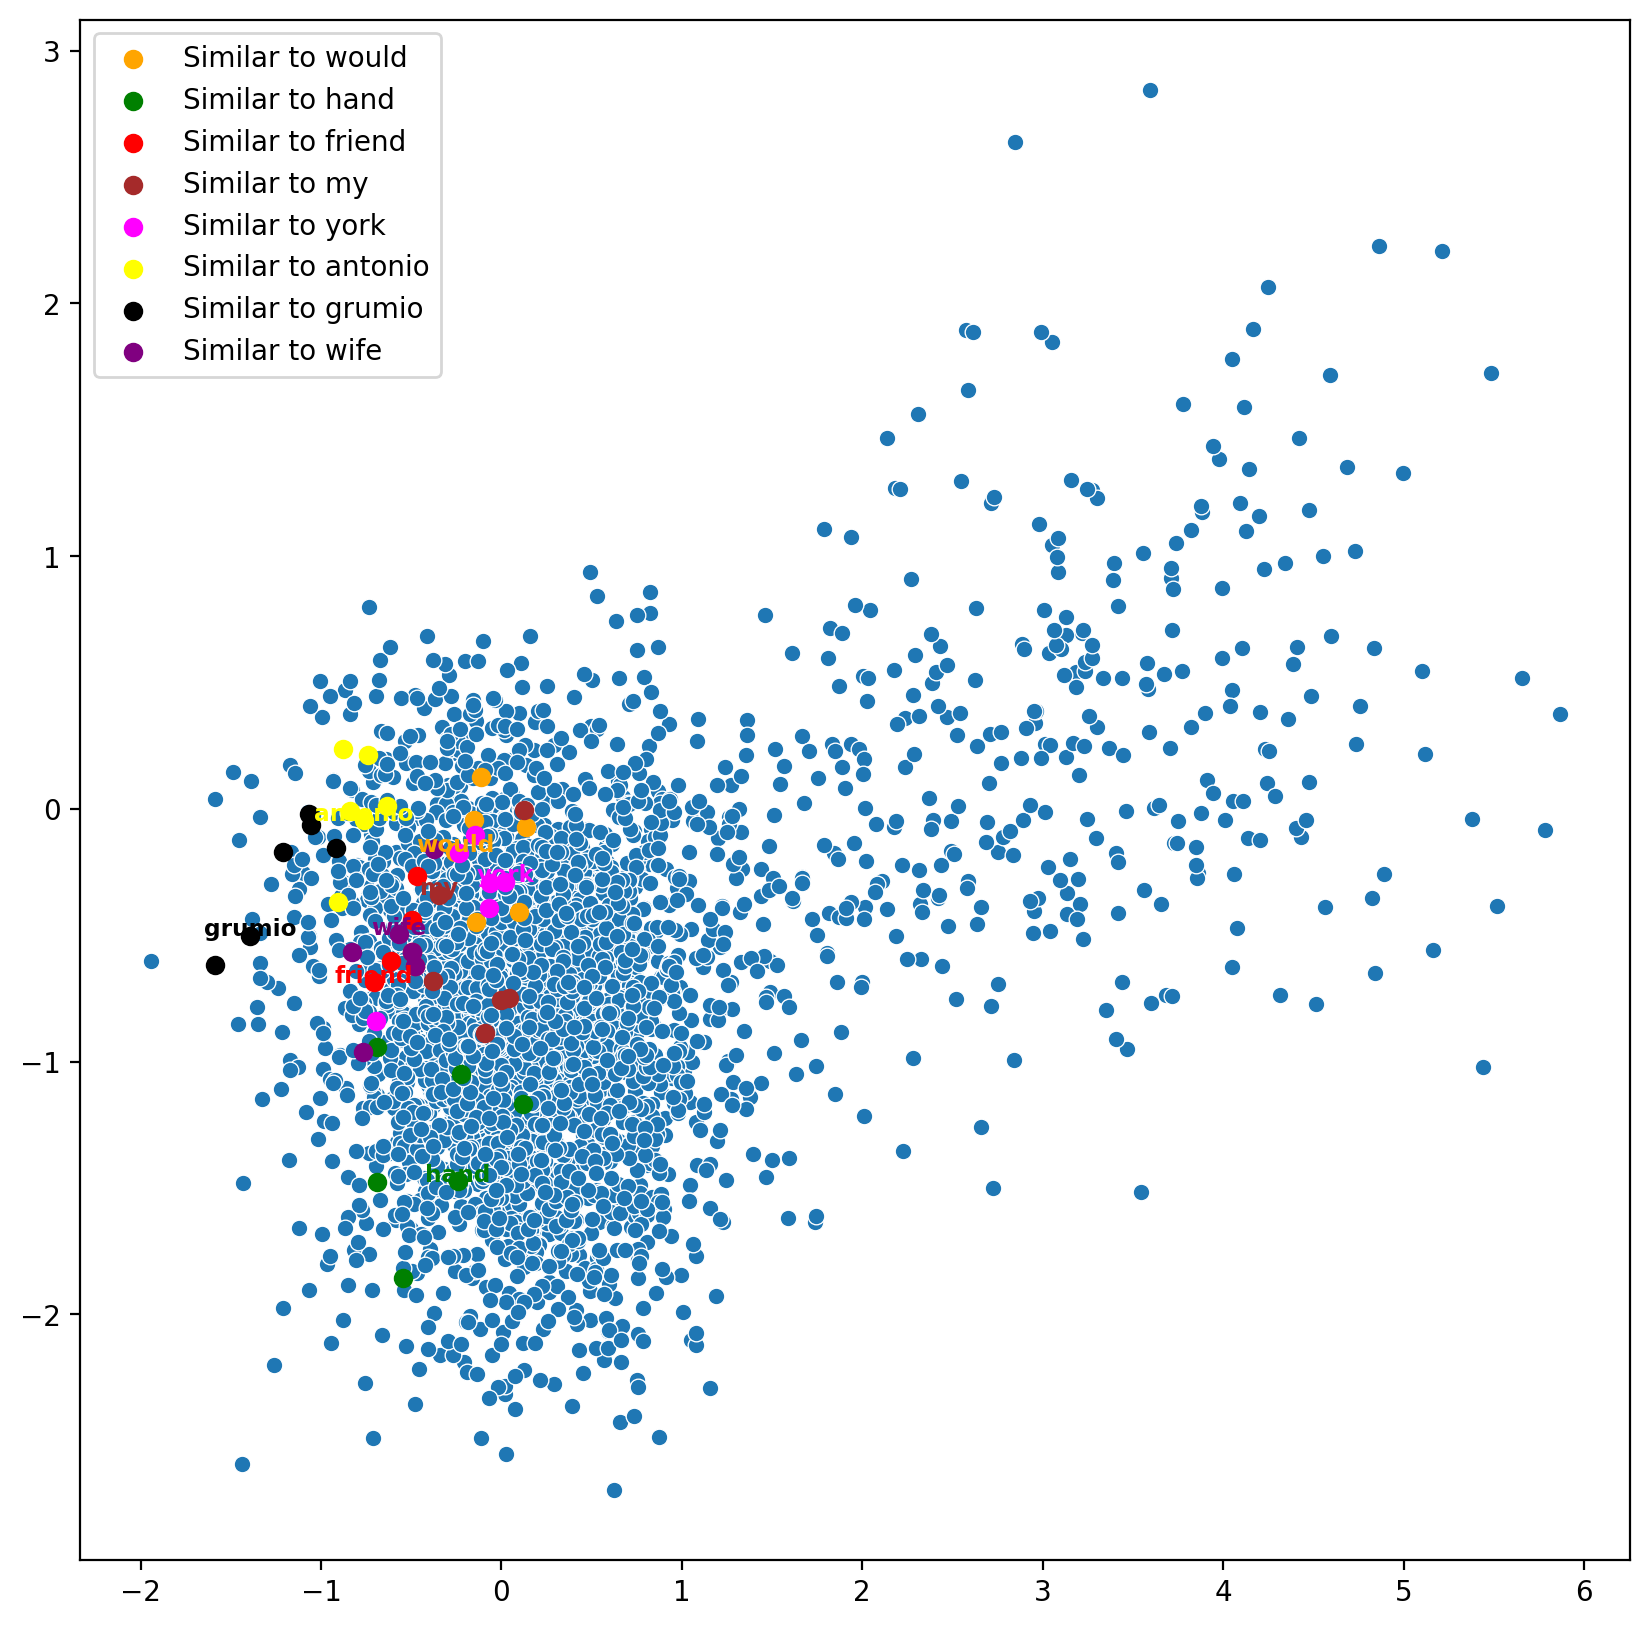

In [78]:
plot_point_features(x_W_dec_PCA, y_W_dec_PCA, most_sim_words)

Again as explained in the other two jupyter notebook the PCA is not performing well to representing the embeddings in 2D space. Indeed as we can see similar words are quite far from similar words excet for the green and yellow clusters that are quite far away from the other set of words, however if we consider a bigger set of words to compare it is very likely that we will see some overlapping points of different similar words.

 ## Summary of Skip-Gram with Negative Sampling

 The main idea behind negative sampling is to transform the original multi-class classification problem into a series of binary classification problems, which helps reduce computational complexity. Now we will discuss the main features of Skip-Gram with Negative Sampling:

 1. In the original Skip-gram model, the objective is to predict the context words given a target word. This involves a softmax function over the entire vocabulary, which can be computationally expensive, especially for large vocabularies.

 2. Negative sampling simplifies the training task by turning it into a binary classification problem. Instead of predicting the context words, Skip-gram now learns to distinguish between true context word pairs (target word, context word) that appear in the training data and randomly sampled "negative" word pairs (target word, randomly chosen word) that do not appear in the context.

 3. To sample negative examples, you randomly select words that do not appear in the context of the target word. The number of negative samples is a hyperparameter that you can control. Common values range from 5 to 20 negative samples per positive example.

 4. Skip-gram with negative sampling aims to maximize the probability of correctly identifying true context word pairs as positive examples while minimizing the probability of incorrectly identifying the sampled negative pairs as positive examples. This is typically achieved using a logistic regression or binary classification objective for each word pair.

 5. By using negative sampling, training the Skip-gram model becomes more efficient because you only need to update a small subset of word pairs in each training iteration (those involved in the positive and negative examples), rather than the entire vocabulary.